In [94]:
import cv2 as cv
import torch

import xml.etree.ElementTree as ET  
from collections import namedtuple
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

Glyph = namedtuple('Glyph', 'name bbox')
BBox = namedtuple('Bbox', 'xmin xmax ymin ymax')

# Portion of the kernel that is exclusive to the previous one
STRIDE_RATIO = 0.8
# Amount of staff space added over the staff lines
BOUNDARY_EXTRA = 4

class MusicFile:
    def __init__(self, filename='', height=0, space=0, column=0, row=0, rot=0, model=[], staff_start=[]):
        self.filename = filename
        self.height = height
        self.space = space
        self.col = column
        self.row = row
        self.rot = rot
        self.model = model
        self.staff_start = staff_start        
        self.img_width = self.img_height = 0
    
    def compute_kernel(self):
        assert self.space and self.height and len(self.model)
        
        self.kernel_size = self.space + self.height    
        self.stride = int(self.kernel_size * STRIDE_RATIO)
        self.n_strides_per_staff = int(len(self.model) / self.stride)
        self.boundary_adjust = BOUNDARY_EXTRA * (self.height + self.space)
        self.n_divisions = int(len(self.model) / self.kernel_size)
        
    # Naive implementation because of the small search space
    # No point into implementing a k-d tree
    def locate(self, glyphs):
        staff_pos = [staff + 2 * (self.space + self.height) + int(self.height / 2) for staff in self.staff_start]
        self.staffs = [[[] for j in range(self.n_divisions)] for  i in range(len(self.staff_start))]
        for glyph in glyphs:
            x = int((glyph.bbox.xmin + glyph.bbox.xmax) / 2) - self.col
            y = int((glyph.bbox.ymin + glyph.bbox.ymax) / 2) + self.row
            
            closest_kernel_idx = int(float(x) / len(self.model) * self.n_divisions)
            # We ignore glyphs outside the staff model in column position
            if closest_kernel_idx >= self.n_divisions:
                continue;
            
            min_dist = self.img_height
            closest_staff_idx = 0
            for i in range(len(staff_pos)):
                dist = abs(y - staff_pos[i])
                if min_dist > dist:
                    min_dist = dist
                    closest_staff_idx = i
            
            self.staffs[closest_staff_idx][closest_kernel_idx].append(glyph)
    
    def extract_samples(self, img):
        return
    
    def visualize(self, img, glyphs=True, div=True):
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        
        if div:
            for i in range(self.n_divisions):
                img = cv.line(img, (self.col + self.kernel_size * i, 0), 
                         (self.col + self.kernel_size * i, self.img_height - 1), (0,0,255), 2)
        
        if glyphs :
            for staff in self.staffs:
                for division in staff:
                    for glyph in division:
                        img = cv.rectangle(img, 
                        (glyph.bbox.xmin, glyph.bbox.ymin), (glyph.bbox.xmax, glyph.bbox.ymax), (255,0,0), 5)
        
        return img

# Function that parses the staff xml and returns a MusicFile object
def staff_xml(fn):
    tree = ET.parse(fn)
    root = tree.getroot()
    assert root.tag == 'AutoScore'
    
    filename = root[0].text
    height = int(root[1][0].text)
    space = int(root[1][1].text)
    column = int(root[1][2].text)
    row = int(root[1][3].text)
    rot = float(root[1][4].text)
    model = [float(gradient) for gradient in str.split(root[1][5].text)]
    staffs = [int(staff.text) for staff in root[2]]

    return MusicFile(filename, height, space, column, row, rot, model, staffs)

'''
Parsing all the staff description xml files for both datasets that were 
generated by deepscores.cc and muscima.cc binaries
'''
artificial_fn = '../datasets/Artificial/'
artificial_files = [f for f in listdir(artificial_fn) if isfile(join(artificial_fn, f))]
handwritten_fn = '../datasets/Handwritten/'
handwritten_files = [f for f in listdir(handwritten_fn) if isfile(join(handwritten_fn, f))]

artificial_files = [staff_xml(join(artificial_fn, f)) for f in artificial_files]
handwritten_files = [staff_xml(join(handwritten_fn, f)) for f in handwritten_files]

# Parsing both datasets' groundtruths
deepscores_fn = '../../data/DEEPSCORES/images_png/'
deepscores_gt_fn = '../../data/DEEPSCORES/xml_annotations/'
muscima_fn = '../../data/MUSCIMA/CvcMuscima-Distortions/'
muscima_gt_fn = '../../data/MUSCIMA/v1.0/data/cropobjects_manual/'

# Functions that parses DEEPSCORES dataset and returns an array of glyphs
def deepscores_gt(filename):
    tree = ET.parse(join(deepscores_gt_fn, os.path.splitext(filename)[0] + '.xml'))
    root = tree.getroot()
    assert root.tag == 'annotation'
    
    width = height = 0
    glyphs = []
    for node in root:
        if node.tag == 'size':
            width = int(node[0].text)
            height = int(node[1].text)
            continue
            
        elif node.tag != 'object':
            continue
            
        assert width and height
        name = node[0].text
        xmin, xmax = int(width * float(node[1][0].text)), int(width * float(node[1][1].text))
        ymin, ymax = int(height * float(node[1][2].text)), int(height * float(node[1][3].text))
        bbox = BBox(xmin, xmax, ymin, ymax)
        glyph = Glyph(name, bbox)
        glyphs.append(glyph)
            
    return glyphs, width, height

for music_file in artificial_files: 
    music_file.compute_kernel()
    glyphs, width, height = deepscores_gt(music_file.filename)
    music_file.img_width, music_file.img_height = width, height
    music_file.locate(glyphs)

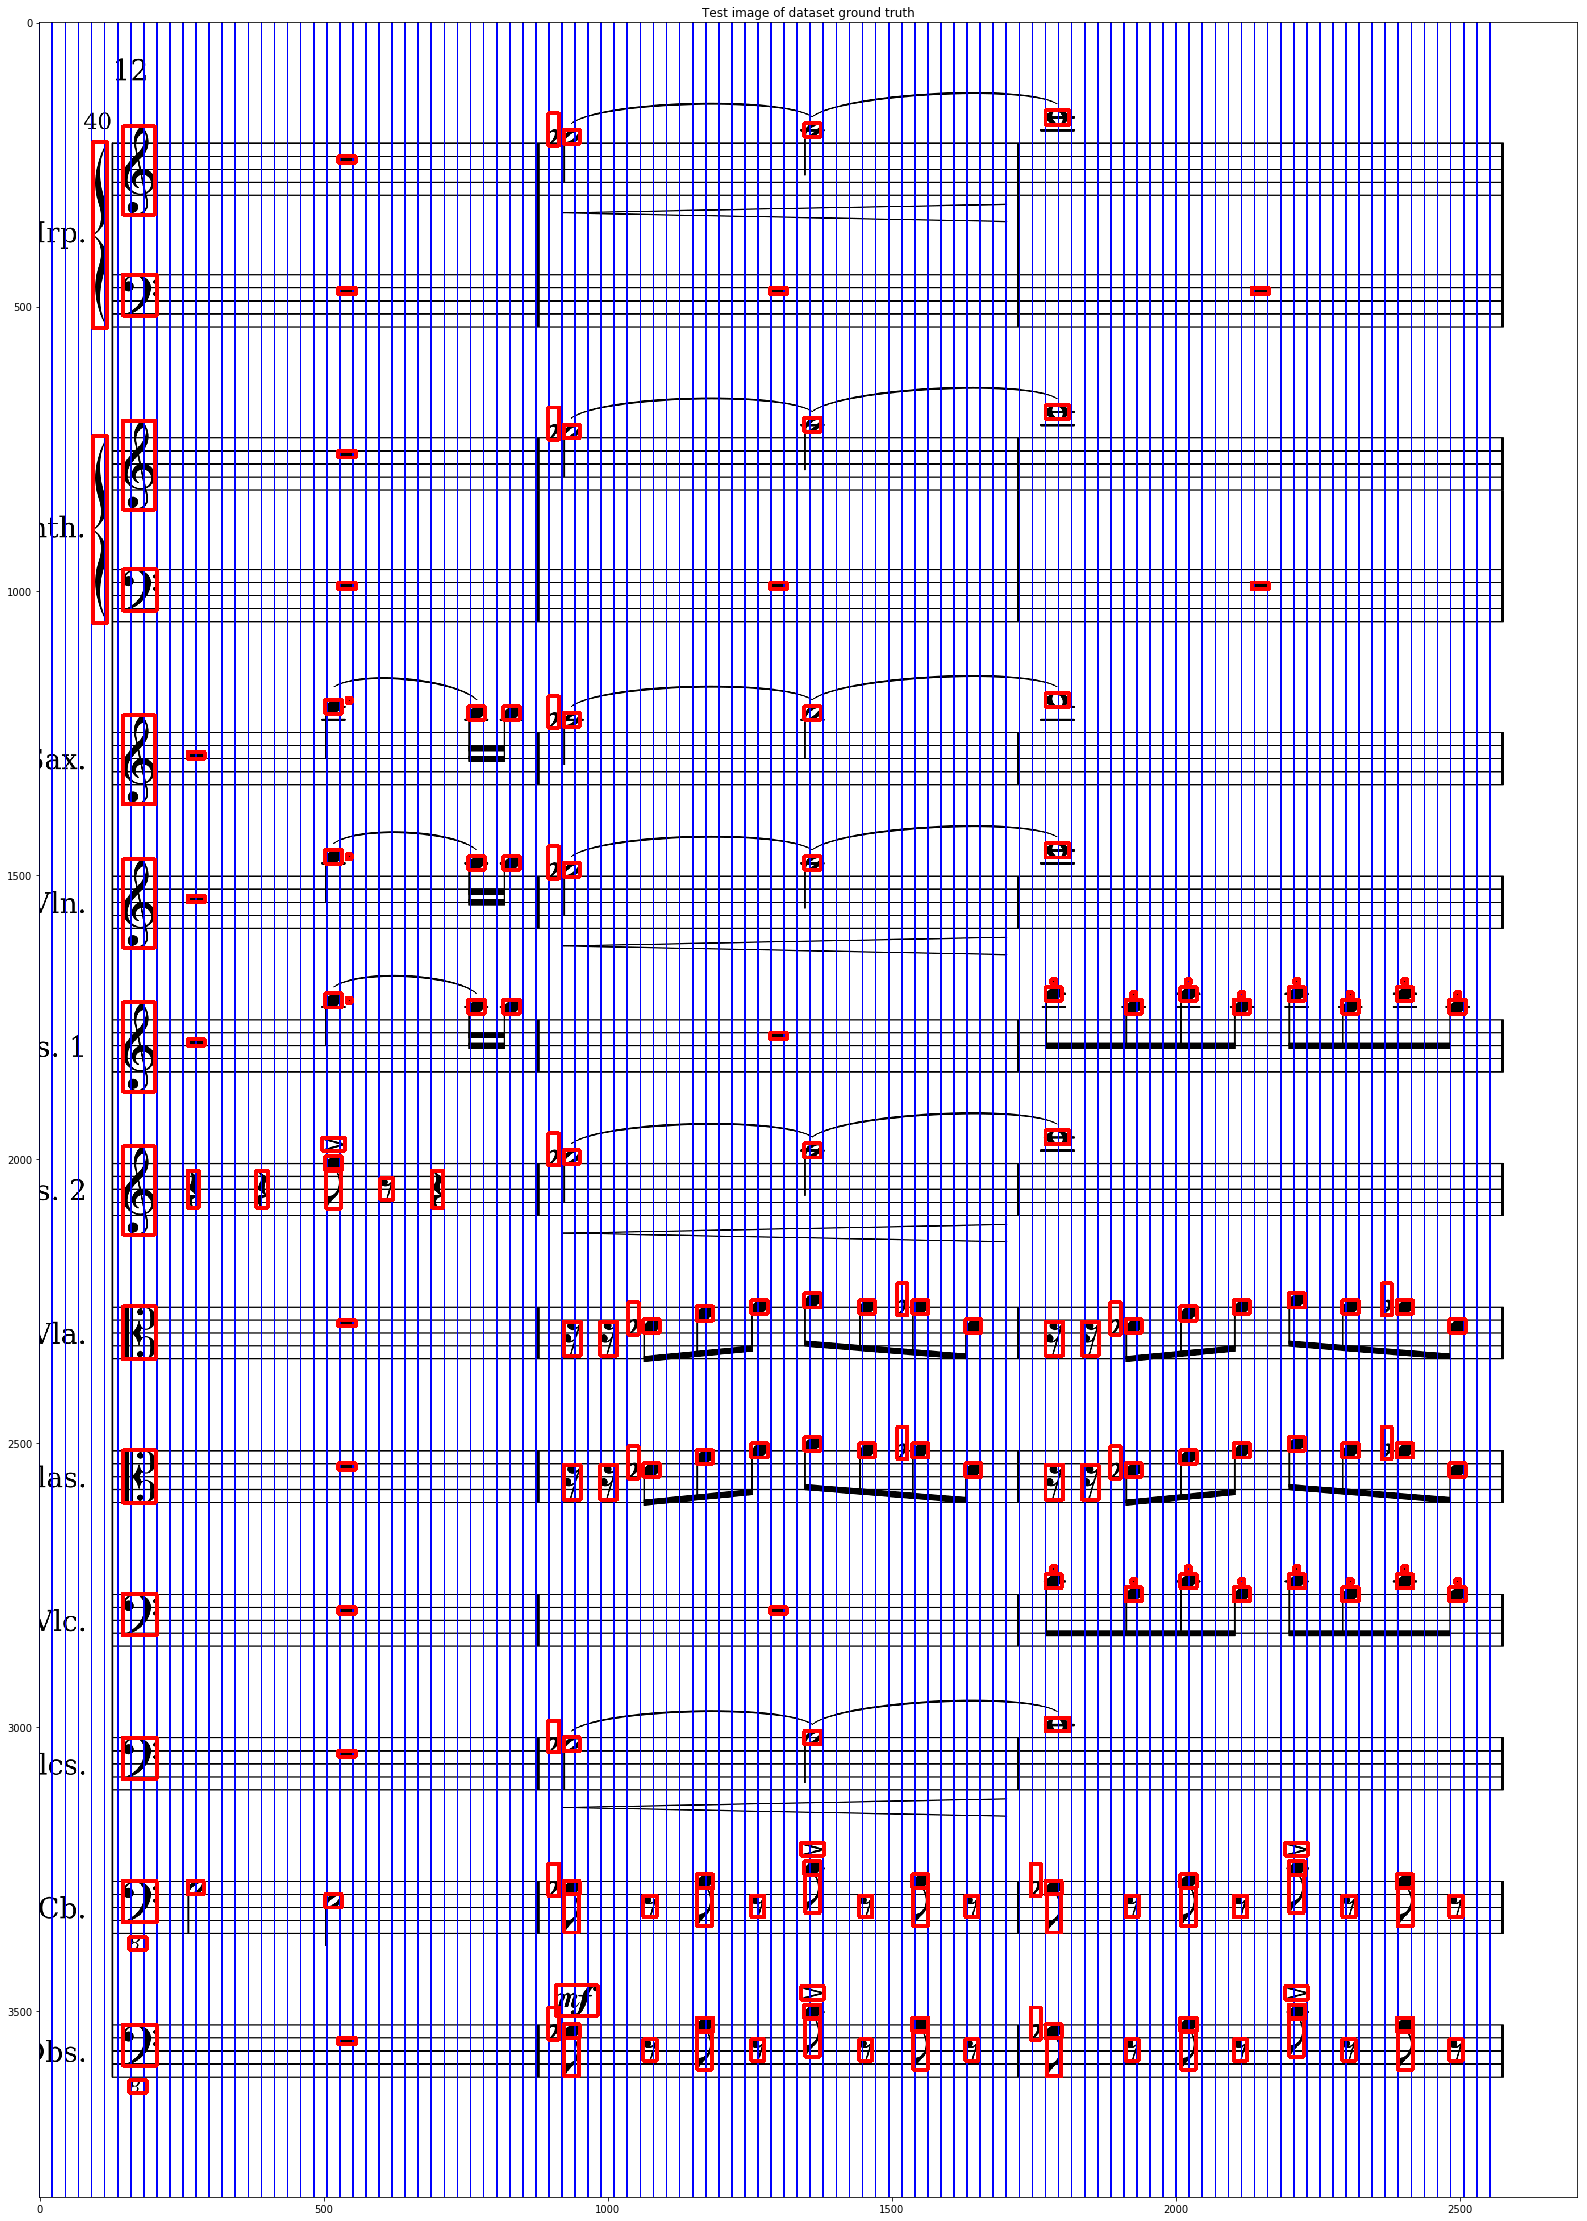

In [100]:
# Visualizing the result
%matplotlib inline

test_filename = artificial_files[0].filename
img = cv.imread(join(deepscores_fn, test_filename), cv.CV_8UC1)
img = artificial_files[0].visualize(img)
    
plt.figure(figsize=(40,40))
plt.imshow(img / 255.0);
plt.title('Test image of dataset ground truth');

In [ ]:
'''
TODO :
1) Implement muscima_gt()
2) Get correspondance between each dataset's labels
3) Morphological transformations to downsample each image
4) Put everything in a python script instead of a notebook
'''